In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import bisect

In [2]:
class Data:
    def __init__(self, x_dim):
        self.xa, self.xb, self.x_grid_size = x_dim
        self.nx = self.x_grid_size + 1
        self.nx0 = self.nx // 2
        self.dx = (self.xb - self.xa) / self.x_grid_size
        self.x = np.linspace(self.xa, self.xb, self.nx)
        
    def get_x(self):
        return self.x

        
class NumericalSolver(Data):
    def __init__(self, x_dim, initial_data, gamma, cfl):
        super().__init__(x_dim)
        self.initial_data = initial_data
        self.gamma = gamma
        self.cfl = cfl
        
        self.n_iters = 0
        self.n_vars = 3 
    
    def initial_solution(self):
        V = np.zeros((self.n_vars, self.nx))
        for i in range(self.n_vars):
            V[i][:self.nx0] = self.initial_data[i][0]
            V[i][self.nx0:] = self.initial_data[i][1]
        return V
    
    def boundary_condition(self, V):
        for i in range(self.n_vars):
            V[i][0] = self.initial_data[i][0]
            V[i][-1] = self.initial_data[i][1]
        return V
    
    def timestep(self, V):
        rho, u, p = V
        sn_max = np.max([np.abs(u) + np.sqrt(self.gamma * p / rho)])
        return self.cfl * self.dx / sn_max
    
    def transform_V_to_U(self, V):
        U = np.zeros((self.n_vars, self.nx))
        U[0] = V[0]
        U[1] = V[0] * V[1]
        U[2] = V[2]/(self.gamma-1) + 0.5 * V[0] * np.square(V[1])
        return U
    
    def transform_U_to_V(self, U):
        V = np.zeros((self.n_vars, self.nx))
        V[0] = U[0]
        V[1] = U[1] / U[0]
        V[2] = (self.gamma-1) * (U[2] - 0.5 * V[0] * np.square(V[1]))
        return V
    
    def calculate_Dx(self, u):
        Dx = np.zeros(self.nx)
        
        # i = 0
        # du/dx(0) = (u(1) - u(0)) / dx
        Dx[0] = (u[1] - u[0]) / self.dx
        # i = 1,nx-1
        # du/dx(i) = (u(i+1) - u(i-1)) / (2*dx)
        Dx[1:-1] = (u[2:] - u[:-2]) / (2*self.dx)
        # i = nx
        # du/dx(nx) = (u(nx) - u(nx-1)) / dx
        Dx[-1] = (u[-1] - u[-2]) / self.dx
        
        return Dx
    
    def calculate_flow_Dx(self, xi, u):
        # i = 1,nx-1
        Dx_xi_u = np.zeros(self.nx)
        
        ur = 0.5*(u[2:] + u[1:-1])
        ul = 0.5*(u[1:-1] + u[:-2])
        
        xi_r_ur = 0.5*xi[1:-1]*(ur + np.abs(ur)) + 0.5*xi[2:]*(ur - np.abs(ur))
        xi_l_ul = 0.5*xi[:-2]*(ul + np.abs(ul)) + 0.5*xi[1:-1]*(ul - np.abs(ul))
        
        Dx_xi_u[1:-1] = (xi_r_ur - xi_l_ul) / self.dx
    
        return Dx_xi_u

    def calculate_R(self, U, V):
        U1, U2, U3 = U
        u, p = V[1:]
        
        # Continuity:
        Dx_rho_u = self.calculate_flow_Dx(U1, u)
        Dt_rho = -Dx_rho_u
        
        # Momentum:
        Dx_rho_uu = self.calculate_flow_Dx(U2, u)
        Dx_p = self.calculate_Dx(p)
        Dt_rho_u = -(Dx_rho_uu + Dx_p)
        
        # Energy:
        Dx_E_u = self.calculate_flow_Dx(U3, u)
        Dx_pu = self.calculate_flow_Dx(p, u)
        Dt_E = -(Dx_E_u + Dx_pu)
        
        R = np.array([
            Dt_rho,
            Dt_rho_u,
            Dt_E
        ])
        return R
    
    def rk4_method(self, U, V, dt):
        Rn = self.calculate_R(U, V)
        # step 1
        U1 = U + 0.5*dt*Rn
        R1 = self.calculate_R(U1, V)
        # step 2
        U2 = U + 0.5*dt*R1
        R2 = self.calculate_R(U2, V)
        # step 3
        U3 = U + dt*R2
        R3 = self.calculate_R(U3, V)
        # step 4
        U_new = U + (Rn + 2.0*R1 + 2.0*R2 + R3)*dt/6
        return U_new
    
    def solve(self, tf):
        V_old = self.initial_solution()
        t = 0
        
        while t <= tf:
            self.n_iters += 1
            dt = self.timestep(V_old)
            t += dt
            
            U_old = self.transform_V_to_U(V_old)
            U_new = self.rk4_method(U_old, V_old, dt)
            V_new = self.transform_U_to_V(U_new)
            V_new = self.boundary_condition(V_new)

            V_old = np.copy(V_new)
        return V_new
    
    
class ExactSolver(Data):
    calculate_a = lambda self, p, rho: np.sqrt(self.gamma * p / rho)
    
    def __init__(self, x_dim, initial_data, gamma):
        super().__init__(x_dim)
        self.initial_data = initial_data
        self.gamma = gamma
        self.n_vars = 3

    def solve(self, tf):
        rho_1, u1, p1 = self.initial_data[:, 0]
        a1 = self.calculate_a(p1, rho_1)
        
        rho_6, u6, p6 = self.initial_data[:, 1]
        A6 = 2 / (rho_6 * (self.gamma+1))
        B6 = rho_6 * (self.gamma-1) / (self.gamma+1)
        
        trascendental_equation = lambda p: (p-p6) * np.sqrt(A6/(p+B6))+2*a1/ (self.gamma-1) * ((p/p1)**((self.gamma-1)/(2*self.gamma)) - 1)+ u6 - u1
        p = bisect(trascendental_equation, 0, 1)
        p3 = p4 = p
        
        u3 = u1 - 2*a1/(self.gamma-1) * ((p3/p1)**((self.gamma-1)/(2*gamma))-1)
        u4 = u6 + (p4-p6) * np.sqrt(A6/(p4+B6))
        
        rho_3 = rho_1 * ((p3/p1)**(1/self.gamma))
        rho_4 = rho_6 * (p6*(self.gamma-1) + p4*(self.gamma+1)) / (p4*(self.gamma-1) + p6*(self.gamma+1))
        
        rho, u, p = np.zeros((self.n_vars, self.nx))
        x0 = self.x[self.nx0]
        
        u_head = u1 - a1
        region1 = self.x - x0 < tf * u_head
        p[region1] = p1
        u[region1] = u1
        rho[region1] = rho_1
        
        a3 = self.calculate_a(p3, rho_3)
        u_tail = u3 - a3
        region2 = (self.x - x0 > tf * u_head) & (self.x - x0 < tf * u_tail)
        x2 = self.x[region2]
        k = (2/(self.gamma+1) + (self.gamma-1) / (a1*(self.gamma+1)) * (u1 - (x2-x0)/tf))
        k1 = k**(2 / (self.gamma-1))
        k2 = k**((2*self.gamma) / (self.gamma-1))
        rho[region2] = rho_1 * k1
        p[region2]=p1 * k2
        u[region2] = 2/(self.gamma+1) * (a1+0.5*(self.gamma-1)*u1 + (x2-x0)/tf)
        
        u_contact = u4
        region3 = (self.x - x0 > tf * u_tail) & (self.x - x0 < tf * u_contact)
        p[region3] = p3
        u[region3] = u3
        rho[region3] = rho_3
        
        a6 = self.calculate_a(p6, rho_6)
        u_shock = u6 + a6 * np.sqrt(p4*(self.gamma+1)/(2*self.gamma*p6) + (self.gamma-1)/(2*self.gamma))
        region4 = (self.x - x0 > tf * u_contact) & (self.x - x0 < tf * u_shock)
        p[region4] = p4
        u[region4] = u4
        rho[region4] = rho_4
        
        # There is no region 5
        
        region6 = tf * u_shock < self.x - x0
        p[region6] = p6
        u[region6] = u6
        rho[region6] = rho_6
        
        return rho, u, p

    
def compare_and_save(x, u_exact, u_appr, tf, variable, file_name):
    plt.plot(x, u_exact, color='green', linestyle='dashed', label='exact solution')
    plt.plot(x, u_appr, color='red', linestyle='dotted', label='RK4 method')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel(variable)
    plt.title(f'{variable} at t = {tf}')
    plt.savefig(file_name)
    np.savez(file_name, u_exact=u_exact, u_appr=u_appr)

In [3]:
xa, xb, x_grid_size = (0, 1, 4000)
x_dim = (xa, xb, x_grid_size)

rho = np.array([1, 0.125])
u = np.array([0, 0])
p = np.array([1, 0.1])
initial_data = np.array([rho, u, p])

gamma = 1.4
cfl = 1e-2
tf = 0.1

In [4]:
data = Data(x_dim)
x = data.get_x()
np.save('array', x)

In [5]:
numerical_solver = NumericalSolver(x_dim, initial_data, gamma, cfl)
exact_solver = ExactSolver(x_dim, initial_data, gamma)

In [6]:
U_appr = numerical_solver.solve(tf)
U_exact = exact_solver.solve(tf)

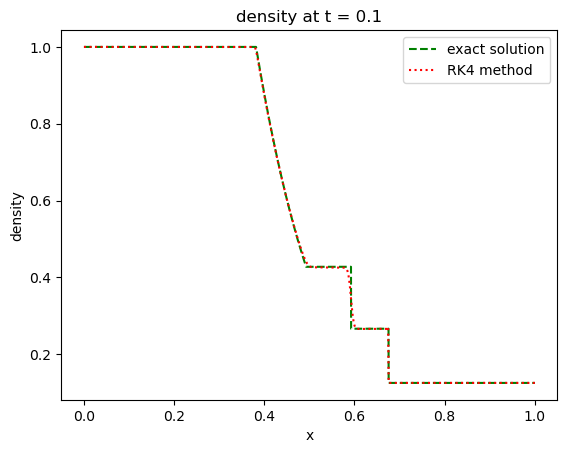

In [7]:
file_name = 'rho_at_01'
compare_and_save(x, U_exact[0], U_appr[0], tf, 'density', file_name)

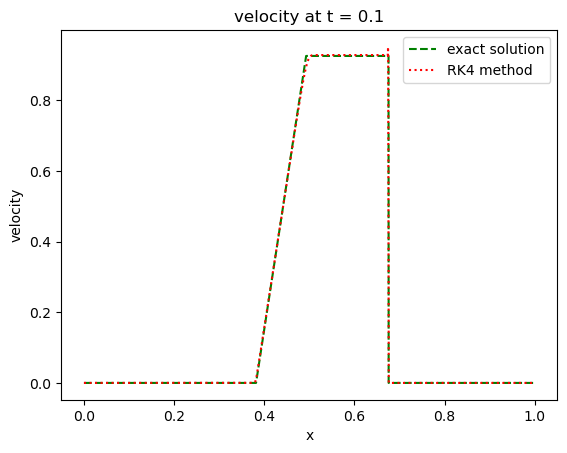

In [8]:
file_name = 'u_at_01'
compare_and_save(x, U_exact[1], U_appr[1], tf, 'velocity', file_name)

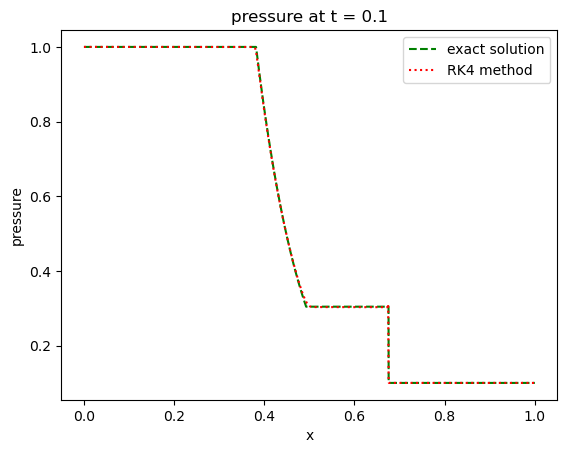

In [9]:
file_name = 'p_at_01'
compare_and_save(x, U_exact[2], U_appr[2], tf, 'pressure', file_name)